In [1]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle
import h5py
import multiprocessing
import itertools
from multiprocessing import sharedctypes
import scipy

In [2]:
def get_spectrum(source_id):
    path = wdtable[wdtable['source_id'] == source_id][0]['specpath']
    try:
        f = fits.open(path)
        flux = f[1].data['flux']
        loglam = f[1].data['loglam']
        f.close()
        lam = 10**loglam
    except:
        print('Spectrum file missing...')
        return
    return lam,flux

In [3]:
wdtable = Table.read('linefits.fits')
wdtable['g_abs'] = wdtable['phot_g_mean_mag'] + 5*np.log10(wdtable['parallax']) - 10
wdtable['bp_rp'] = wdtable['phot_bp_mean_mag'] - wdtable['phot_rp_mean_mag']
DA = (wdtable['spectral_class'] == 'DA')*\
        (wdtable['S/N'] > 5)
DAwdtable = wdtable[DA]
len(DAwdtable)

14624

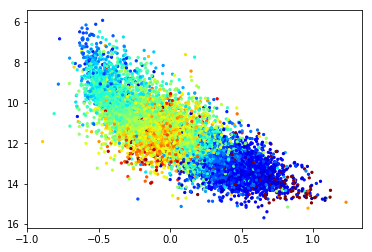

In [4]:
plt.scatter(DAwdtable['bp_rp'],DAwdtable['g_abs'], s = 5, c = DAwdtable['fwhm_b'], vmax = 100, cmap = 'jet')
plt.gca().invert_yaxis()

In [110]:
bgrid = np.linspace(np.min(DAwdtable['bp_rp']),np.max(DAwdtable['bp_rp']),20)
ggrid = np.linspace(np.min(DAwdtable['g_abs']),np.max(DAwdtable['g_abs']),20)
bint = bgrid[1]-bgrid[0]
gint = ggrid[1]-ggrid[0]

In [120]:
snidxs[-5:]

8
4
1
2
9


In [121]:
selections = [];
for i in tqdm(bgrid):
    for j in ggrid:
        square = (DAwdtable['bp_rp'] > i)*(DAwdtable['g_abs'] > j)*\
                (DAwdtable['bp_rp'] < i+bint)*(DAwdtable['g_abs'] < j+gint)
        if len(DAwdtable[square]) > 0:
            snidxs = np.argsort(DAwdtable[square]['S/N'])
            snmaxidxs = np.array(snidxs[-10:])
            for jj in snmaxidxs:
                selections.append(DAwdtable[square][int(jj)]['source_id'])

 10%|█         | 2/20 [00:00<00:06,  2.64it/s]


KeyboardInterrupt: 

In [95]:
idxs = [];
for i in selections:
    idxs.append(np.argmax(DAwdtable['source_id'] == i))

In [96]:
selectiontable = DAwdtable[idxs]
len(selectiontable)

1355

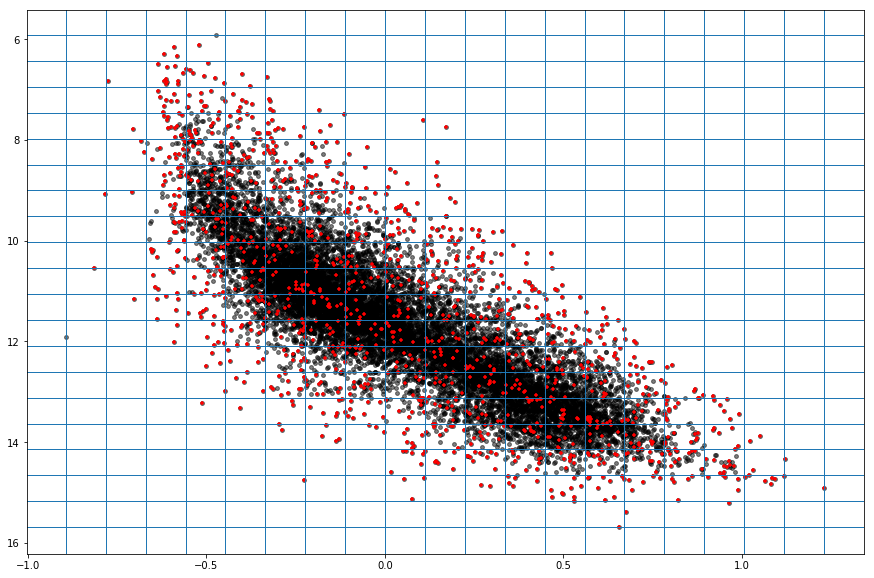

In [97]:
plt.figure(figsize=(15,10))
plt.scatter(DAwdtable['bp_rp'],DAwdtable['g_abs'],s=15,color='k',alpha=0.5)
plt.scatter(selectiontable['bp_rp'],selectiontable['g_abs'],s=15,color='r',marker='+')
plt.gca().invert_yaxis()
for i in range(len(bgrid)):
    plt.axvline(bgrid[i],linewidth=1)
    plt.axhline(ggrid[i],linewidth=1)

In [98]:
lamgrid = np.arange(4000,7000)
lam = lamgrid
lamgrid = lam
lines = ((lam > hbeta-150) & (lam < hbeta + 150)) | ((lam > halpha-100) & (lam < halpha + 100))\
        | ((lam > hgamma-90) & (lam < hgamma + 120))| ((lam > hdelta-70) & (lam < hdelta + 70))

mask = ~lines
def quadratic(array,c1,c2,c3,c4):
    return c1 + c2*array + c3*array**2 + c4*array**3

In [99]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler
import multiprocessing

In [100]:
bprps = np.asarray(selectiontable['bp_rp'])
absgs = np.asarray(selectiontable['g_abs'])

In [101]:
interpfluxs = [];
lamgrid = np.arange(4000,7000)
for i in tqdm(range(len(selectiontable))):
    spec = get_spectrum(selectiontable['source_id'][i])
    lam  = spec[0]
    flux = spec[1]
    trans = ((selectiontable['center_b'][i] - hbeta)+(selectiontable['center_a'][i]-halpha))/2
    shiftedflux = interpolation.shift(flux,-trans,cval=np.nan)
    func = interp1d(lam,flux,kind='linear',assume_sorted = False,fill_value='extrapolate')
    interpflux = func(lamgrid)
    interpfluxs.append(interpflux)

100%|██████████| 1355/1355 [00:35<00:00, 38.04it/s]


In [19]:
spectra = np.asarray(interpfluxs)
normspec = [];

for i in tqdm(range(len(spectra))):
    p,cov = curve_fit(quadratic,lamgrid[mask],spectra[i][mask],p0=[-25,1e-2,1e-5,1e-10])
    contcorr = (spectra[i]/quadratic(lamgrid,p[0],p[1],p[2],p[3]))
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10)
    contcorr[skylinemask] = 1.
    where = np.isnan(contcorr)
    contcorr[where] = 1.
    normspec.append(contcorr)
normspec = np.asarray(normspec)
len(normspec)

100%|██████████| 1355/1355 [00:01<00:00, 1180.33it/s]


1355

In [102]:
where = (normspec > 1.25) + (normspec < 0)
normspec[where] = 1.

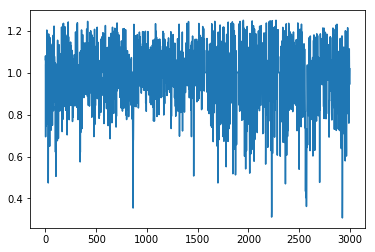

In [123]:
plt.plot(normspec[1234])

In [124]:
np.argsort([1,2,3,4,5])

array([0, 1, 2, 3, 4])

In [125]:
sc = MinMaxScaler()
msc = MinMaxScaler()
X = sc.fit_transform(np.stack((bprps,absgs)).transpose())
t = msc.fit_transform(normspec)

X_train,X_test,y_train,y_test = train_test_split(X,t,test_size=0.05)

In [141]:
def generator():
    x = Input(shape=(2,))
    y = Dense(256,activation='relu')(x)
    y = Dropout(0.5)(y)
    y = Dense(256,activation='relu')(y)
    y = Dropout(0.5)(y)
    out = Dense(3000,activation='linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adam(lr=0.01), loss = 'mse', \
                  metrics = ['mean_absolute_percentage_error'])
    return model
model = generator()
print(model.summary())
model.load_weights('outlier_DA_256.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               768       
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 3000)              771000    
Total params: 837,560
Trainable params: 837,560
Non-trainable params: 0
_________________________________________________________________
None

In [142]:
history = [];
for i in range(1):
    print('Training meta-batch %i'%i)
    epoch = 250
    batch = len(X_train)
    for i in tqdm(range(epoch)):
        h = model.fit(X_train,y_train,epochs=1,verbose=0,batch_size=batch)
        history.append(h.history['loss'][0])
    model.save_weights('outlier_DA_256.h5')

  0%|          | 0/250 [00:00<?, ?it/s]

Training meta-batch 0


100%|██████████| 250/250 [00:24<00:00, 10.09it/s]


Text(0.5, 1.0, '0.22 percent improvement')

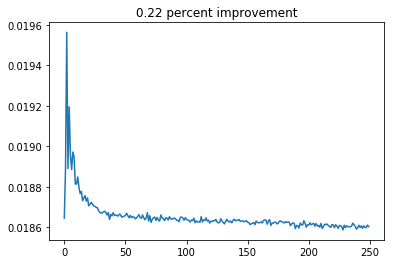

In [143]:
plt.plot(history)
plt.title('%.2f percent improvement' % -(((history[-1]-history[0])/history[0])*100))

In [144]:
predlabels = (X_test)
preds = msc.inverse_transform(model.predict(predlabels))

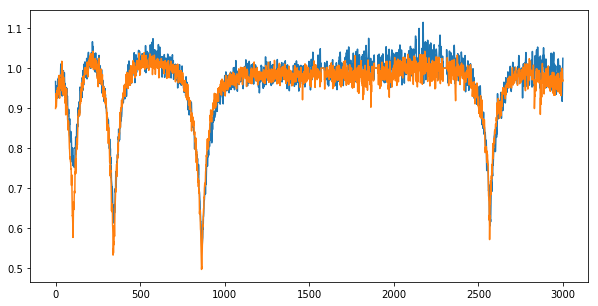

In [151]:
i = np.random.randint(0,len(X_test))
plt.figure(figsize=(10,5))
plt.plot(msc.inverse_transform(y_test)[i])
plt.plot(preds[i])
#plt.plot(msc.inverse_transform(y_test)[i]-preds[i])

Text(0.5, 1.0, 'H-Beta Line')

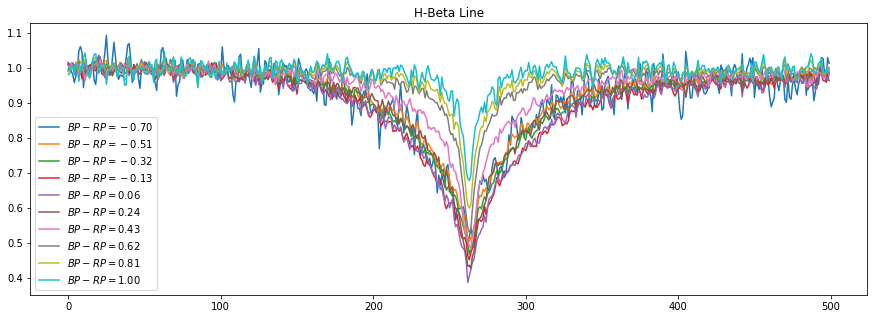

In [153]:
plt.figure(figsize=(15,5))
ts = np.linspace(-0.7,1,10)
ls = np.linspace(12,12,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(gens[i][600:1100],label='$BP-RP = %.2f$'%ts[i])
plt.legend(fontsize=10)
plt.title('H-Beta Line')

Text(0.5, 1.0, 'H-Beta Line')

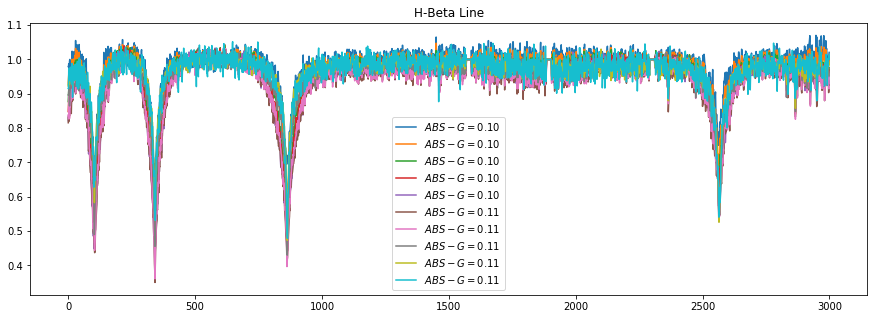

In [155]:
plt.figure(figsize=(15,5))
ts = np.linspace(0.1,0.11,10)
ls = np.linspace(7,15,10)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(gens[i],label='$ABS-G = %.2f$'%ts[i])
plt.legend(fontsize=10)
plt.title('H-Beta Line')